# Setup

In [102]:
import sqlite3
import pandas as pd
import importlib
import typedstream as ts
import re
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
import plotly as ply
import re
from src import functions as f
from src import dictionaries
import numpy as np



db_path = "/Users/nmarks/Library/Messages/chat.db"  # Adjust path as needed
conn = sqlite3.connect(db_path)

importlib.reload(f)

<module 'src.functions' from '/Users/nmarks/root_code_repo/dopetracks_summary/src/functions.py'>

# 0 Data prep

## 0a Pull data

In [171]:
# this is the table with all the messages.
messages_raw = pd.read_sql_query('''
                             select *, 
                                datetime(date/1000000000 + strftime("%s", "2001-01-01") ,"unixepoch","localtime")  as date_utc 
                             from message 
                             ORDER BY date DESC
                             ''', conn) 

# handles and contact info
handles = pd.read_sql_query("select * from handle", conn)

# attachments 
attachments = pd.read_sql_query(
    '''
   SELECT mime_type,
       filename"
       message_id
   FROM attachment
   INNER JOIN message_attachment_join
      ON attachment.ROWID = attachment_id
   ''', conn)


# table mapping each message_id to its chat_id
chat_message_joins = pd.read_sql_query("select * from chat_message_join", conn)

# table mapping each chat_id to the handles that are part of that chat.
chat_handle_join = pd.read_sql_query("select * from chat_handle_join", conn)

DatabaseError: Execution failed on sql '
   SELECT mime_type,
       filename"
       message_id
   FROM attachment
   INNER JOIN message_attachment_join
      ON attachment.ROWID = attachment_id
   ': unrecognized token: ""
       message_id
   FROM attachment
   INNER JOIN message_attachment_join
      ON attachment.ROWID = attachment_id
   "

## 0b Clean data

In [69]:
# renaming some fields for better code readability
messages_raw.rename(columns={'ROWID':'message_id'}, inplace=True)
handles.rename(columns = {'ROWID' : 'handle_id'}, inplace=True)
handles.rename(columns = {'id' : 'contact_info'}, inplace=True)

## 0c Joins + variable creation

In [70]:
# add the chat_id for each message_id
messages = pd.merge(messages_raw, chat_message_joins, how='left', on='message_id').head(39)

# convert the dates and timestamps from strings to dates for cleaner plots
messages['timestamp'] = messages['date_utc'].apply(lambda x: pd.Timestamp(x))
messages['date'] = messages['timestamp'].apply(lambda x: x.date())
messages['date'] = pd.to_datetime(messages['date'], errors='coerce')

# get the contact info of each handle into one dataframe
chat_handle_contact_info = pd.merge(chat_handle_join, handles[['handle_id','contact_info']], on='handle_id', how='left')

# group by the chat and get a list of handles and contact info for each chat.
handle_contact_list_per_chat = pd.DataFrame({'chat_members_handles': chat_handle_contact_info.groupby('chat_id')['handle_id'].unique(),
                                              'chat_members_contact_info':chat_handle_contact_info.groupby('chat_id')['contact_info'].unique()}).reset_index()

# then join that to the messages table 
messages = pd.merge(messages, handle_contact_list_per_chat, on='chat_id', how='left')
messages['chat_members_handles'] = messages['chat_members_handles'].fillna('')
messages['chat_members_contact_info'] = messages['chat_members_contact_info'].fillna('')

# create a field with the chat size of each message. This is mostly for analytics purporses
messages['chat_size'] = messages['chat_members_handles'].apply(f.get_chat_size)


# get the contact info for the handle_id column, i.e., who sent or received the message.
messages = pd.merge(messages, handles[['handle_id', 'contact_info']], on='handle_id', how='left')

# extract message date from attributedBody
messages['extracted_message'] = messages['attributedBody'].apply(
    lambda x: f.extract_text_from_typedstream(x)
    )

# combine text
conditions = [
    pd.notna(messages['text']) & (messages['text'] != 'None'),  # CASE 1
    (pd.isna(messages['text']) | (messages['text'] == 'None')) & pd.notna(messages['extracted_message'])  # CASE 2
]

# Define results for each CASE
choices = [
    messages['text'],               # THEN use 'text'
    messages['extracted_message']   # THEN use 'extracted_message'
]

# Default ELSE value
default = messages['text']

messages['text_final'] = np.select(conditions, choices, default=default)


# messages['text_final'] = messages.apply(
#     lambda row: row['text'] if pd.notna(row['text']) and row['text'] != 'None' 
#     else row['extracted_message'], 
#     axis=1
# )

messages['urls'] = messages['text_final'].apply(lambda x: f.extract_urls(x))


Error extracting text: Attempted to read 2 bytes of data, but only got 0 bytes


In [156]:
def parse_binary_message(data):
    """
    Parse a binary attributedBody message and extract text and metadata.

    Parameters:
        data (bytes): Serialized binary data.

    Returns:
        dict: Extracted text and metadata.
    """
    result = {"text": None, "metadata": {}}

    try:
        if not data:  # Handle empty or invalid binary data
            return result

        # Parse the binary data
        parsed = typedstream.unarchive_from_data(data)

        # Extract text
        try:
            if hasattr(parsed, 'contents') and len(parsed.contents) > 0:
                first_content = parsed.contents[0]
                if hasattr(first_content, 'value') and hasattr(first_content.value, 'value'):
                    result["text"] = first_content.value.value
                else:
                    result["text"] = str(first_content)
        except Exception as e:
            print(f"Error extracting text: {e}")

        # Extract metadata
        try:
            for content in parsed.contents:
                if hasattr(content, 'value') and isinstance(content.value, dict):
                    result["metadata"].update(content.value)
        except Exception as e:
            print(f"Error extracting metadata: {e}")

    except Exception as e:
        print(f"Error parsing binary message: {e}")

    return result


In [163]:
messages['testing'] = messages['attributedBody'].head(20).apply(parse_binary_message)
messages[['testing','text','attributedBody']].head(20)

,testing,text,attributedBody
0,"{'text': 'https://youtu.be/nzDn3Ifmd0k', 'meta...",https://youtu.be/nzDn3Ifmd0k,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...
1,"{'text': 'Confirmed', 'metadata': {}}",Confirmed,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...
2,{'text': 'I need acknowledgement of this by on...,I need acknowledgement of this by one of you p...,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...
3,{'text': 'They’re literally making us test at ...,They’re literally making us test at their hous...,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...
4,"{'text': None, 'metadata': {}}",None,None
5,{'text': 'Tell them when you get here that you...,Tell them when you get here that you tested @ ...,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...
6,"{'text': 'Liked “Dinner served @6:30”', 'metad...",Liked “Dinner served @6:30”,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...
7,"{'text': 'Ya reg cardamom is fine', 'metadata'...",Ya reg cardamom is fine,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...
8,{'text': 'They’re out of it. Think we can sub?...,They’re out of it. Think we can sub?,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...
9,"{'text': '￼', 'metadata': {}}",￼,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84...


In [166]:
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None):
    f.display_scrollable(
        # messages[['message_id', 'testing','text','attributedBody']].head(20)
        messages[messages['message_id'] == 426240]
        # messages[(messages['contact_info'] == '+12485141896') & (messages['message_id'] == 426235)][['message_id','text_final','timestamp']]
        
        
        # messages[messages['contact_info'] == '+12485141896'].sort_values('date_utc', ascending=False)
    )

message_id,guid,text,replace,service_center,handle_id,subject,country,attributedBody,version,type,service,account,account_guid,error,date,date_read,date_delivered,is_delivered,is_finished,is_emote,is_from_me,is_empty,is_delayed,is_auto_reply,is_prepared,is_read,is_system_message,is_sent,has_dd_results,is_service_message,is_forward,was_downgraded,is_archive,cache_has_attachments,cache_roomnames,was_data_detected,was_deduplicated,is_audio_message,is_played,date_played,item_type,other_handle,group_title,group_action_type,share_status,share_direction,is_expirable,expire_state,message_action_type,message_source,associated_message_guid,associated_message_type,balloon_bundle_id,payload_data,expressive_send_style_id,associated_message_range_location,associated_message_range_length,time_expressive_send_played,message_summary_info,ck_sync_state,ck_record_id,ck_record_change_tag,destination_caller_id,is_corrupt,reply_to_guid,sort_id,is_spam,has_unseen_mention,thread_originator_guid,thread_originator_part,syndication_ranges,synced_syndication_ranges,was_delivered_quietly,did_notify_recipient,date_retracted,date_edited,was_detonated,part_count,is_stewie,is_sos,is_critical,bia_reference_id,is_kt_verified,fallback_hash,date_utc,chat_id,message_date,timestamp,chat_members_handles,chat_members_contact_info,chat_size,contact_info,extracted_message,text_final,urls,testing
426240,D8692487-C04C-45FE-8DEE-FD4549474947,None,0,None,237,None,None,None,10,1,iMessage,E:nmarkspdx@gmail.com,4466378A-7751-4DC4-9BA9-7C653609827A,0,2024-12-21,756511517706055936,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,chat979403484344371862,1,0,0,0,0,0,0,None,0,0,0,0,0,0,0,None,0,None,None,None,0,0,0,"b'bplist00\xd4\x01\x02\x03\x04\x05\x06\x07\rSamcSustSotrRrp\x10\x00\t\xd1\x08\tQ0\xd2\n\x0b\x05\x0cRloRle\x10\x03\xa1\x05\x08\x11\x15\x19\x1d ""#&(-035\x00\x00\x00\x00\x00\x00\x01\x01\x00\x00\x00\x00\x00\x00\x00\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x007'",0,,,+15035040080,0,9F2AD557-DA91-4DCC-83DC-8E27F9E932D5,0,0,0,None,None,None,None,0,0,0,756511516148674432,0,0,0,0,0,None,0,None,2024-12-21 17:04:59,4178.0,7.565115e+17,2024-12-21 17:04:59,"[13, 237, 3]","[+12699932026, +12485052468, +12485141896]",3,+12485052468,,,[],"{'text': None, 'metadata': {}}"


In [45]:
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None):
    f.display_scrollable(
        messages[
            (messages['chat_id'].isin([286, 16])) & 
            (messages['contact_info'] == '+15037037962') &
            (
                (messages['text_final'].apply(lambda x: bool(re.search('open.spotify', str(x))))) |
                (messages['contact_info'] == '+15037037962') &
                (messages['urls'].apply(len) > 0)
            )
        ][['message_id','text_final','text','attributedBody' ]]
        # [['message_id','chat_id', 'date', 'timestamp', 'chat_members_handles', 'contact_info', 'urls', 'text_final','attributedBody', 'text']]
        .head(2000),
        height=400
    )



message_id,text_final,text,attributedBody
426152,Good luck. Great time last night!,None,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84\x84\x84\x19NSMutableAttributedString\x00\x84\x84\x12NSAttributedString\x00\x84\x84\x08NSObject\x00\x85\x92\x84\x84\x84\x0fNSMutableString\x01\x84\x84\x08NSString\x01\x95\x84\x01+!Good luck. Great time last night!\x86\x84\x02iI\x01!\x92\x84\x84\x84\x0cNSDictionary\x00\x95\x84\x01i\x01\x92\x84\x98\x98\x1d__kIMMessagePartAttributeName\x86\x92\x84\x84\x84\x08NSNumber\x00\x84\x84\x07NSValue\x00\x95\x84\x01*\x84\x9b\x9b\x00\x86\x86\x86'
426151,"Ah fun, but I’m on a flight to Michigan right now. No leads for you",None,"b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84\x84\x84\x19NSMutableAttributedString\x00\x84\x84\x12NSAttributedString\x00\x84\x84\x08NSObject\x00\x85\x92\x84\x84\x84\x0fNSMutableString\x01\x84\x84\x08NSString\x01\x95\x84\x01+EAh fun, but I\xe2\x80\x99m on a flight to Michigan right now. No leads for you\x86\x84\x02iI\x01C\x92\x84\x84\x84\x0cNSDictionary\x00\x95\x84\x01i\x01\x92\x84\x98\x98\x1d__kIMMessagePartAttributeName\x86\x92\x84\x84\x84\x08NSNumber\x00\x84\x84\x07NSValue\x00\x95\x84\x01*\x84\x9b\x9b\x00\x86\x86\x86'"
426150,You want to play basketball tn? We need a player in my league. Or know anyone who might be interested?,None,b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84\x84\x84\x12NSAttributedString\x00\x84\x84\x08NSObject\x00\x85\x92\x84\x84\x84\x08NSString\x01\x94\x84\x01+gYou want to play basketball tn? We need a player in my league. Or know anyone who might be interested? \x86\x84\x02iI\x01g\x92\x84\x84\x84\x0cNSDictionary\x00\x94\x84\x01i\x01\x92\x84\x96\x96\x1d__kIMMessagePartAttributeName\x86\x92\x84\x84\x84\x08NSNumber\x00\x84\x84\x07NSValue\x00\x94\x84\x01*\x84\x99\x99\x00\x86\x86\x86'
426149,Your order number is KIO128.\n\nClick below to view your receipt.\nhttps://admin.mobilebytes.com/receipt/6551/53504938-3658-4A7D-9A4E-0586C236450F,None,"b'\x04\x0bstreamtyped\x81\xe8\x03\x84\x01@\x84\x84\x84\x19NSMutableAttributedString\x00\x84\x84\x12NSAttributedString\x00\x84\x84\x08NSObject\x00\x85\x92\x84\x84\x84\x0fNSMutableString\x01\x84\x84\x08NSString\x01\x95\x84\x01+\x81\x8f\x00Your order number is KIO128.\n\nClick below to view your receipt.\nhttps://admin.mobilebytes.com/receipt/6551/53504938-3658-4A7D-9A4E-0586C236450F\x86\x84\x02iI\x01@\x92\x84\x84\x84\x0cNSDictionary\x00\x95\x84\x01i\x01\x92\x84\x98\x98\x1d__kIMMessagePartAttributeName\x86\x92\x84\x84\x84\x08NSNumber\x00\x84\x84\x07NSValue\x00\x95\x84\x01*\x84\x9b\x9b\x00\x86\x86\x99\x02O\x92\x84\x9a\x9b\x03\x92\x84\x98\x98\x1e__kIMDataDetectedAttributeName\x86\x92\x84\x84\x84\x06NSData\x00\x95\x9b\x81a\x02\x84\x06[609c]bplist00\xd4\x01\x02\x03\x04\x05\x06\x07\x0cX$versionY$archiverT$topX$objects\x12\x00\x01\x86\xa0_\x10\x0fNSKeyedArchiver\xd2\x08\t\n\x0bWversionYdd-result\x80\x0b\x80\x01\xac\r\x0e\x1c$%&,-.259U$null\xd7\x0f\x10\x11\x12\x13\x14\x15\x16\x17\x18\x19\x1a\x1b\x1aRMSV$classRARQTQPRSRRVN\x80\x06\x80\n\x80\x02\x80\x07\x10\x01\x80\x08\xd4\x1d\x1e\x1f\x10 !""#_\x10\x12NS.rangeval.length_\x10\x14NS.rangeval.locationZNS.special\x80\x03\x80\x04\x10\x04\x80\x05\x10O\x10@\xd2\'()*Z$classnameX$classesWNSValue\xa2)+XNSObject_\x10Ohttps://admin.mobilebytes.com/receipt/6551/53504938-3658-4A7D-9A4E-0586C236450FWHttpURL\xd2/\x1001ZNS.objects\xa0\x80\t\xd2\'(34WNSArray\xa23+\xd2\'(67_\x10\x0fDDScannerResult\xa28+_\x10\x0fDDScannerResult\x10\x01\x00\x08\x00\x11\x00\x1a\x00$\x00)\x002\x007\x00I\x00N\x00V\x00`\x00b\x00d\x00q\x00w\x00\x86\x00\x89\x00\x90\x00\x93\x00\x95\x00\x97\x00\x9a\x00\x9d\x00\x9f\x00\xa1\x00\xa3\x00\xa5\x00\xa7\x00\xa9\x00\xb2\x00\xc7\x00\xde\x00\xe9\x00\xeb\x00\xed\x00\xef\x00\xf1\x00\xf3\x00\xf5\x00\xfa\x01\x05\x01\x0e\x01\x16\x01\x19\x01""\x01t\x01|\x01\x81\x01\x8c\x01\x8d\x01\x8f\x01\x94\x01\x9c\x01\x9f\x01\xa4\x01\xb6\x01\xb9\x01\xcb\x00\x00\x00\x00\x00\x00\x02\x01\x00\x00\x00\x00\x00\x00\x00:\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\xcd\x86\x92\x9b\x92\x9c\x92\x84\x98\x98\x16_

In [63]:
with pd.option_context('display.max_colwidth', None, 'display.max_columns', None):
    f.display_scrollable(
        messages[
            (messages['message_id'].isin([426114])) 
        ]
        # [['message_id','chat_id', 'date', 'timestamp', 'chat_members_handles', 'contact_info', 'urls', 'text_final','attributedBody', 'text']]
        .head(2000),
        height=400
    )



message_id,guid,text,replace,service_center,handle_id,subject,country,attributedBody,version,type,service,account,account_guid,error,date,date_read,date_delivered,is_delivered,is_finished,is_emote,is_from_me,is_empty,is_delayed,is_auto_reply,is_prepared,is_read,is_system_message,is_sent,has_dd_results,is_service_message,is_forward,was_downgraded,is_archive,cache_has_attachments,cache_roomnames,was_data_detected,was_deduplicated,is_audio_message,is_played,date_played,item_type,other_handle,group_title,group_action_type,share_status,share_direction,is_expirable,expire_state,message_action_type,message_source,associated_message_guid,associated_message_type,balloon_bundle_id,payload_data,expressive_send_style_id,associated_message_range_location,associated_message_range_length,time_expressive_send_played,message_summary_info,ck_sync_state,ck_record_id,ck_record_change_tag,destination_caller_id,is_corrupt,reply_to_guid,sort_id,is_spam,has_unseen_mention,thread_originator_guid,thread_originator_part,syndication_ranges,synced_syndication_ranges,was_delivered_quietly,did_notify_recipient,date_retracted,date_edited,was_detonated,part_count,is_stewie,is_sos,is_critical,bia_reference_id,is_kt_verified,fallback_hash,date_utc,chat_id,message_date,timestamp,chat_members_handles,chat_members_contact_info,chat_size,contact_info,extracted_message,text_final,urls
426114,F001AC9E-51C8-4E18-BD72-D0FF392F8198,None,0,None,115,None,None,None,10,0,iMessage,E:nmarkspdx@gmail.com,4466378A-7751-4DC4-9BA9-7C653609827A,0,2024-12-17,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,chat619291522977762275,1,0,0,0,0,1,3246,None,0,0,0,0,0,0,0,None,0,None,None,None,0,0,0,None,0,None,None,None,0,None,0,0,0,None,None,None,None,0,0,0,0,0,0,0,0,0,None,0,None,2024-12-17 20:29:20,61.0,7.561890e+17,2024-12-17 20:29:20,"[107, 108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 121, 122, 123, 124, 125, 126, 127, 129, 130, 132, 3107, 3246]","[+14157205817, +12039621730, +17189094216, +16506276009, +12025495832, +19164175890, +15166975200, +15035087208, +14133626393, +16173352729, +12038038910, +14257867038, +14159098585, +19292139458, +14152728552, +12035245014, +19788863596, +19293199490, +14156869069, +14077821258, +19089389620, +15856236982, +14159907836, +16175998866]",24,+15035087208,,,[]


# 1 Data Exploration

# Appendix

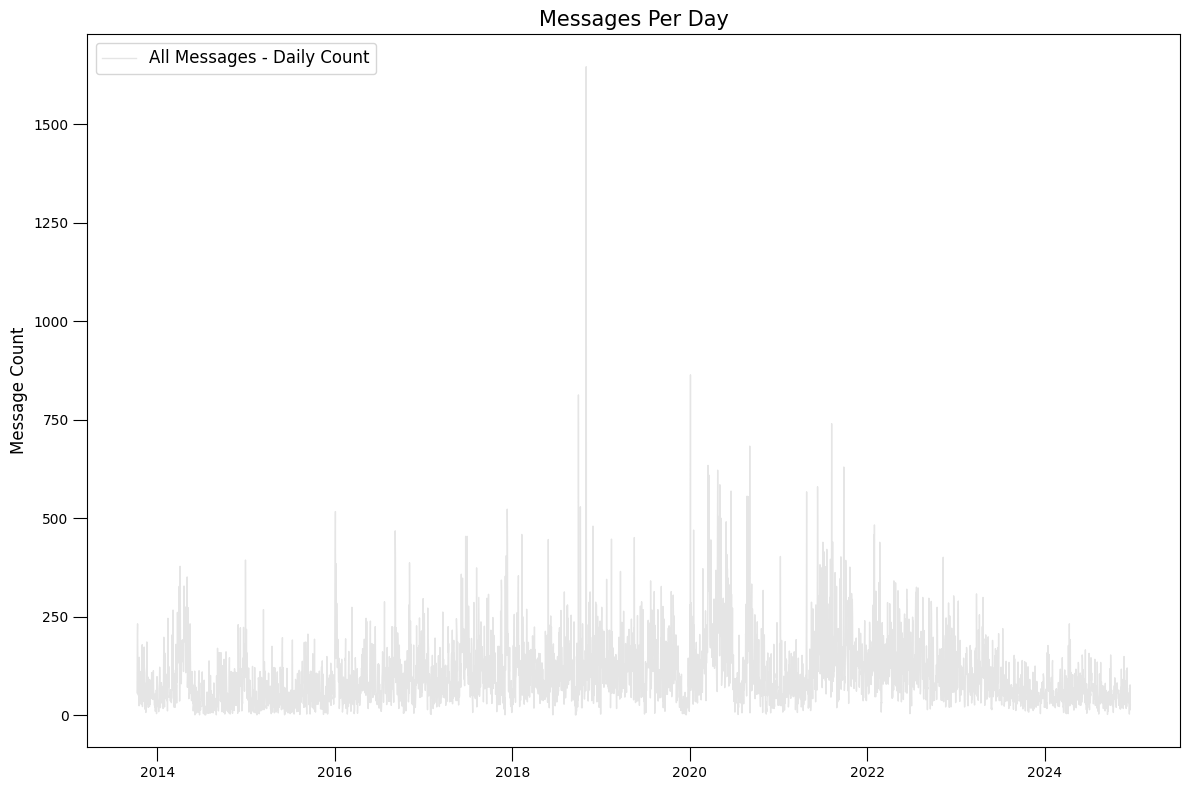

In [81]:
# Messages per day
import plotly.tools as tls
import plotly.io as pio

plt.figure(figsize=(12,8))

plt.title("Messages Per Day", fontsize=15)

daily_count = messages.groupby('date').size()
daily_count_received = messages.loc[messages['is_service_message']==0].groupby('date').size()

# plot
plt.plot(daily_count, color='grey',lw=1, alpha=0.2, label='All Messages - Daily Count')

plt.legend(loc='upper left', fontsize='large')
plt.ylabel('Message Count', fontsize=12)
plt.tick_params(size=10)
plt.tight_layout()



In [82]:
messages.groupby('date').size().reset_index(name='count').sort_values(by = 'count', ascending=False)

,date,count
1836,2018-11-01,1646
2265,2020-01-04,864
1804,2018-09-30,813
2846,2021-08-07,740
2509,2020-09-04,683
...,...,...
600,2015-06-09,1
2247,2019-12-17,1
277,2014-07-16,1
280,2014-07-19,1


# Testing